# Data Mining Project: Predicting Student Behavioral Disruptions


## Library Requirements
Install the required libraries specified in the `requirements.txt` file. You can do this using pip:
```bash
pip install -r requirements.txt
```


## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Initial Exploration](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Hypothesis Testing](#hypothesis-testing)
5. [Feature Engineering](#feature-engineering)
6. [Model Development](#model-development)
7. [Model Evaluation and Interpretation](#model-evaluation)
8. [Result Cleanup](#result-cleanup)


## 1. Introduction
This notebook documents our team's effort to predict and analyze student behavioral disruptions to minimize in-class interruptions.

**Team Members:**  
**Customer:** Adam West

**Objectives:**
- Predict behavioral disruptions
- Identify anomalous patterns
- Provide clear interpretations


## 2. Data Loading and Initial Exploration

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bus_conduct = pd.read_csv('TTU Data - Bus Conduct.csv')
bus_conduct_updated = pd.read_csv('TTU Data Update - Bus Conduct.csv')
family_engagement = pd.read_csv('TTU Data - Family Engagement.csv')
disciplinary_referral = pd.read_csv('TTU Data - Disciplinary Referral.csv')
disciplinary_referral_updated = pd.read_csv('TTU Data Update - Disciplinary Referral.csv')


print("Bus Conduct Dataset:")
display(bus_conduct.head())
print("Bus Conduct Updated Dataset:")
display(bus_conduct_updated.head())

print("Family Engagement Dataset:")
display(family_engagement.head())

print("Disciplinary Referral Dataset:")
display(disciplinary_referral.head())

print("Disciplinary Referral Updated Dataset:")
display(disciplinary_referral_updated.head())


Bus Conduct Dataset:


,School,Date of Incident,Bus Route: Check all that Apply,Type of Incident: Check all that Apply - Selected Choice,"As the school bus driver, I have taken the following actions: - Selected Choice",Year,Term,Student Identifier,bus.dr,Ethnicity,Gender,Grade_Level
0,Hill Valley High School,08/06/2024,Return Trip Home,"Throwing objects on or from the bus,Violation ...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
1,Hill Valley High School,08/09/2024,Route to School,"Willful disobedience,Other",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14788361BZD,1,W,M,1
2,Hill Valley High School,08/09/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
3,Rydell High School,08/16/2024,Return Trip Home,"Intentional violation of bus rules,Willful dis...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14069825BZD,1,W,M,3
4,Rydell High School,08/16/2024,Return Trip Home,"Intentional violation of bus rules,Willful dis...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15382187BZD,1,W,M,2


Bus Conduct Updated Dataset:


,School,Date of Incident,Bus Route: Check all that Apply,Type of Incident: Check all that Apply - Selected Choice,"As the school bus driver, I have taken the following actions: - Selected Choice",Year,Term,Student Identifier,bus.dr,Ethnicity,Gender,Grade_Level
0,Hill Valley High School,08/06/2024,Return Trip Home,"Throwing objects on or from the bus,Violation ...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
1,Hill Valley High School,08/09/2024,Route to School,"Willful disobedience,Other",Request school administrator assistance ASAP!,2024 - 2025,1Q,A14788361BZD,1,W,M,1
2,Cookeville High,08/07/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A13076150BZD,1,H,F,9
3,Hill Valley High School,08/09/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A15878405BZD,2,W,M,2
4,Cookeville High,08/13/2024,Return Trip Home,"Intentional violation of bus rules,Being disre...",Request school administrator assistance ASAP!,2024 - 2025,1Q,A13286285BZD,1,W,F,10


Family Engagement Dataset:


,I am responding as a - Selected Choice,I am responding as a - Other - Text,My ethnic/race background is - Selected Choice,My ethnic/race background is - Other - Text,Please check which school your child/children attends.,How many children in total do you have attending the school selected above? (This will ensure you only have to complete one survey per school your children attend.),Have you completed the 2024-2025 Family Engagement survey for another child/School?,How likely are you to recommend Putnam County Schools to a friend or family member? - Group,How likely are you to recommend Putnam County Schools to a friend or family member?,Please respond to the following statements regarding your student(s): - I understand the academic standards and curriculum that my child/children are expected to learn at their grade level.,...,Please answer the following statements: - I have access to the internet.,Please answer the following statements: - I would like to have some school meetings in places other than the school.,Please answer the following statements: - I know that child care and/or transportation are available for a Family Engagement event if needed.,Please answer the following statements: - PCSS has a Return to School plan. Have you been able to review that?,Please answer the following statements: - PCSS has a Safe Return to In-Person Instruction and Continuity of Services plan. Have you been able to review that?,Please answer the following statements: - PCSS has a Federal Relief Spending Plan on the ESSER website. Have you been able to review that?,"If you cannot attend school activities, please select any that apply. - Selected Choice","If you cannot attend school activities, please select any that apply. - Other (please specify) - Text",What time of day would be best for you to attend a family engagement activity or meeting? (Check all that\napply.) - Selected Choice,What time of day would be best for you to attend a family engagement activity or meeting? (Check all that\napply.) - Other (please specify) - Text
0,Parent,NaN,Asian,NaN,Rydell High School,1,No,Passive,7,Agree,...,Yes,Yes,Yes,Yes,Yes,Yes,My work schedule,NaN,Early Evening (5:00 PM or Later),NaN
1,Parent,NaN,Hispanic/Latino,NaN,Hill Valley High School School,2,No,Promoter,10,Agree,...,Yes,Yes,Yes,Yes,Yes,Yes,My work schedule,NaN,"During School,Early Evening (5:00 PM or Later)",NaN
2,Parent,NaN,White/Caucasian,NaN,Hill Valley High School School,1,No,Promoter,10,Agree,...,Yes,No,Yes,Yes,Yes,No,"My work schedule,Too busy",NaN,Early Evening (5:00 PM or Later),NaN
3,Parent,NaN,White/Caucasian,NaN,Rydell High School,2,No,Detractor,6,Disagree,...,Yes,No,Yes,No,No,No,NaN,NaN,Early Evening (5:00 PM or Later),NaN
4,Parent,NaN,White/Caucasian,NaN,Hill Valley High School School,1,No,Detractor,5,Disagree,...,Yes,No,Yes,Yes,Yes,Yes,My work schedule,NaN,Other (please specify),I worl 12 hours shifts


Disciplinary Referral Dataset:


,Please select your school,Time of the Day the behavior occurred?,Date of Incident,Is the referral for a minor or a major violation?,Select the Classroom Managed Behavior (Do not include student names in text boxes) - Selected Choice,Select the Major Referral,Where did the incident take place?,Enrollment_SchoolID,Ethnicity,fre,Gender,Grade_Level,LunchStatus,Student Identifier,Year,Term,dr.studentminors
0,Hill Valley High School,2:00pm -3:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Misuse of electronic devices,NaN,Media Center,5,W,W,M,0,P,A16817795BZD,2024-2025,2Q,1
1,Hill Valley High School,12:00pm - 1:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Classroom,5,W,W,M,0,P,A16817795BZD,2024-2025,2Q,2
2,Shermer High School,8:00am - 9:00am,05/06/2024,Minor Violation (5 times in the same quarter),Tardiness,NaN,Cafeteria,105,H,"W,H",M,11,F,A12046745BZD,2023-2024,4Q,1
3,Hill Valley High School,2:00pm -3:00pm,11/18/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Media Center,5,W,W,M,0,P,A16732493BZD,2024-2025,2Q,1
4,Rydell High School,8:00am - 9:00am,08/26/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,Classroom,35,W,W,M,-1,P,A16747199BZD,2024-2025,1Q,1


Disciplinary Referral Updated Dataset:


,Please select your school,Time of the Day the behavior occurred?,Date of Incident,Is the referral for a minor or a major violation?,Select the Classroom Managed Behavior (Do not include student names in text boxes) - Selected Choice,Select the Major Referral,Ethnicity,Gender,Grade_Level,LunchStatus,Student_Number
0,Bayside,11:00am - 12:00pm,08/06/2024,Minor Violation (5 times in the same quarter),Other,NaN,W,M,4,F,A14843549BZD
1,Shermer High School,11:00am - 12:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,9,F,A12943094BZD
2,Shermer High School,11:00am - 12:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,9,F,A13368554BZD
3,Shermer High School,1:00pm - 2:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Disobedience/Defiance/Disrespect,NaN,W,M,10,P,A12732407BZD
4,Bayside,2:00pm -3:00pm,08/13/2024,Minor Violation (5 times in the same quarter),Other,NaN,W,M,2,R,A15849737BZD


## 3. Exploratory Data Analysis (EDA)

In [20]:

bus_conduct['Date of Incident'] = pd.to_datetime(bus_conduct['Date of Incident'])
disciplinary_referral['Date of Incident'] = pd.to_datetime(disciplinary_referral['Date of Incident'])

print("Missing values in Bus Conduct Dataa:")
print(bus_conduct.isnull().sum())

print("\nMissing values in Disciplinary Referral Data:")
print(disciplinary_referral.isnull().sum())


Missing values in Bus Conduct Dataa:
School                                                                             0
Date of Incident                                                                   1
Bus Route: Check all that Apply                                                    0
Type of Incident: Check all that Apply - Selected Choice                           0
As the school bus driver, I have taken the following actions: - Selected Choice    0
Year                                                                               0
Term                                                                               0
Student Identifier                                                                 0
bus.dr                                                                             0
Ethnicity                                                                          0
Gender                                                                             0
Grade_Level                 

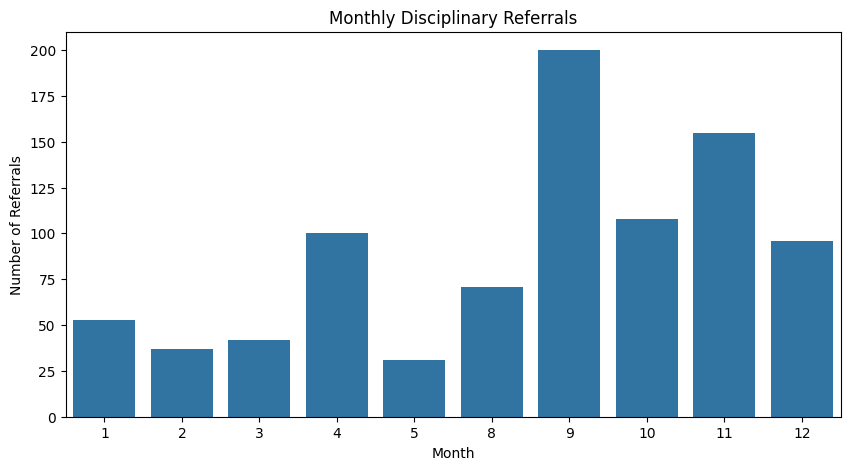

In [21]:

disciplinary_referral['Month'] = disciplinary_referral['Date of Incident'].dt.month
monthly_referrals = disciplinary_referral.groupby('Month').size()

plt.figure(figsize=(10,5))
sns.barplot(x=monthly_referrals.index, y=monthly_referrals.values)
plt.title('Monthly Disciplinary Referrals')
plt.xlabel('Month')
plt.ylabel('Number of Referrals')
plt.show()


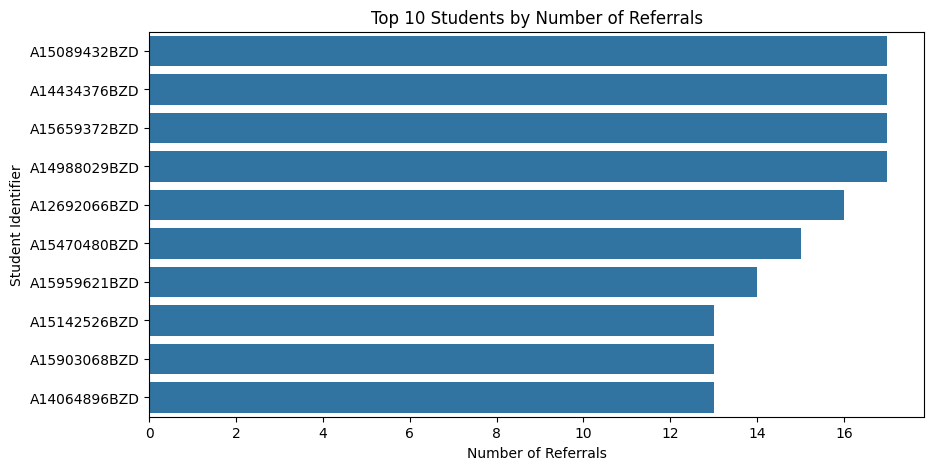

In [22]:

frequent_students = disciplinary_referral['Student Identifier'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(y=frequent_students.index, x=frequent_students.values, orient='h')
plt.title('Top 10 Students by Number of Referrals')
plt.xlabel('Number of Referrals')
plt.ylabel('Student Identifier')
plt.show()


C:\Users\thoma\AppData\Local\Temp\ipykernel_10808\2931003169.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = disciplinary_referral.groupby(["Grade_Level", "Time_Category"]).size().unstack().fillna(0)


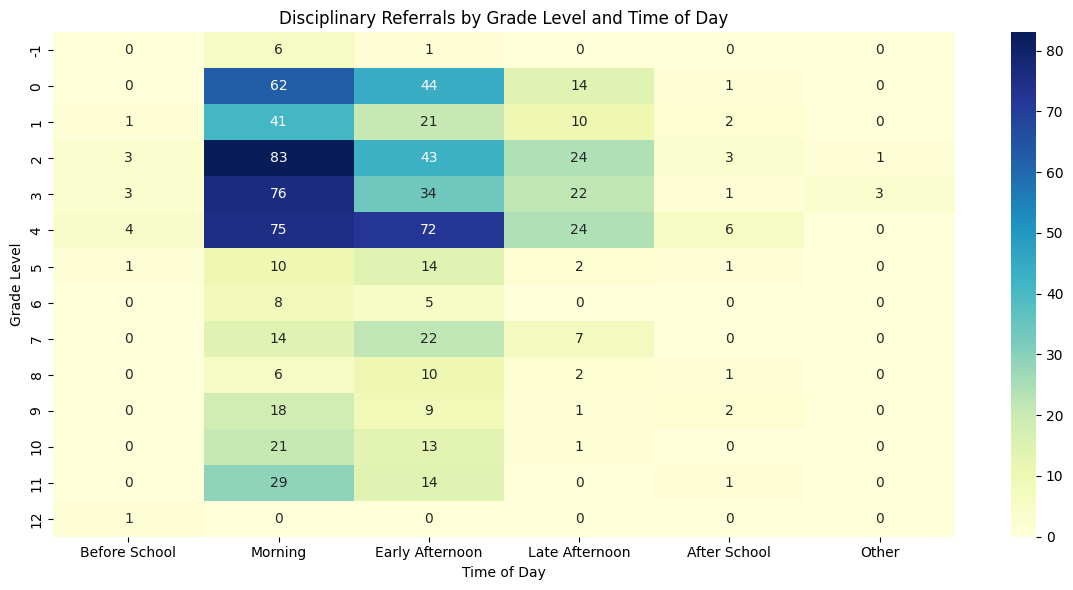

In [23]:
# categorize time of day
def categorize_time(time_str):
    if pd.isna(time_str):
        return "Unknown"
    time_str = time_str.lower().strip()
    if "before school" in time_str:
        return "Before School"
    elif any(t in time_str for t in ["8:00am", "9:00am", "10:00am", "11:00am"]):
        return "Morning"
    elif any(t in time_str for t in ["12:00pm", "1:00pm"]):
        return "Early Afternoon"
    elif any(t in time_str for t in ["2:00pm", "3:00pm"]):
        return "Late Afternoon"
    elif "after school" in time_str:
        return "After School"
    else:
        return "Other"

# apply the function
disciplinary_referral["Time_Category"] = disciplinary_referral["Time of the Day the behavior occurred?"].apply(categorize_time)

# set custom category order
time_order = ["Before School", "Morning", "Early Afternoon", "Late Afternoon", "After School", "Other"]
disciplinary_referral["Time_Category"] = pd.Categorical(
    disciplinary_referral["Time_Category"],
    categories=time_order,
    ordered=True
)

# group the data
grouped = disciplinary_referral.groupby(["Grade_Level", "Time_Category"]).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(grouped, annot=True, cmap="YlGnBu")
plt.title("Disciplinary Referrals by Grade Level and Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Grade Level")
plt.tight_layout()
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_10808\323041730.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_referrals = merged_df.groupby('Temp_Category')['referral_count'].mean().reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_10808\323041730.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_referrals, x='Temp_Category', y='referral_count', palette='coolwarm')


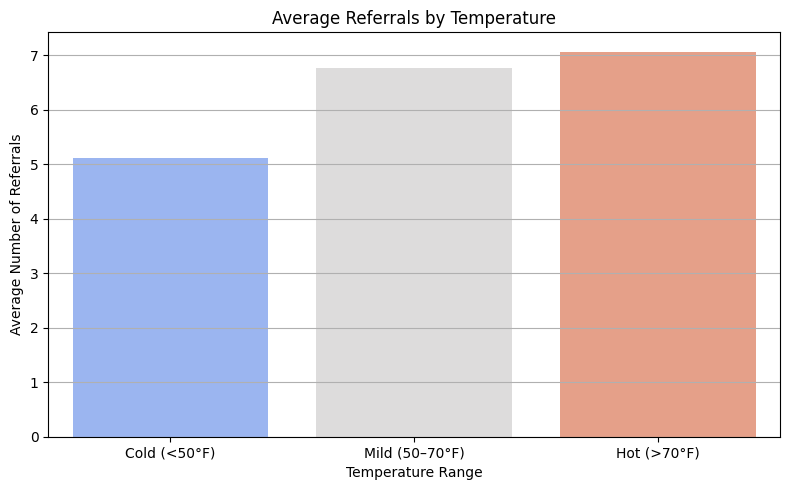

In [24]:
weather_df = pd.read_csv("weather.csv")

# convert date columns to datetime
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors='coerce')
disciplinary_referral['Date of Incident'] = pd.to_datetime(disciplinary_referral['Date of Incident'], errors='coerce')

# count number of referrals per day
referrals_per_day = disciplinary_referral.groupby('Date of Incident').size().reset_index(name='referral_count')

# merge on date
merged_df = pd.merge(referrals_per_day, weather_df, how='inner', left_on='Date of Incident', right_on='datetime')
merged_df.drop(columns=['datetime'], inplace=True)

# bin temp into categories
bins = [0, 50, 70, 100]
labels = ['Cold (<50°F)', 'Mild (50–70°F)', 'Hot (>70°F)']
merged_df['Temp_Category'] = pd.cut(merged_df['temp'], bins=bins, labels=labels)

# group by temperature bin and calculate average referrals
binned_referrals = merged_df.groupby('Temp_Category')['referral_count'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=binned_referrals, x='Temp_Category', y='referral_count', palette='coolwarm')
plt.title('Average Referrals by Temperature')
plt.ylabel('Average Number of Referrals')
plt.xlabel('Temperature Range')
plt.grid(True, axis='y')
plt.tight_layout() 
plt.show()

## 4. Hypothesis Testing
*(To be completed by team)*

## 5. Feature Engineering
*(To be completed by team)*

## 6. Model Development
*(To be completed by team)*

In [25]:
#  Merging all the datasets into one model ready dataset
# Reload datasets
original_ref = pd.read_csv("TTU Data - Disciplinary Referral.csv")
update_ref = pd.read_csv("TTU Data Update - Disciplinary Referral.csv")
original_bus = pd.read_csv("TTU Data - Bus Conduct.csv")
update_bus = pd.read_csv("TTU Data Update - Bus Conduct.csv")
family_engagement = pd.read_csv("TTU Data - Family Engagement.csv")
weather = pd.read_csv("weather.csv")

# Merge referrals
all_ref_columns = list(set(original_ref.columns).union(set(update_ref.columns)))
original_ref = original_ref.reindex(columns=all_ref_columns)
update_ref = update_ref.reindex(columns=all_ref_columns)
full_ref = pd.concat([original_ref, update_ref], ignore_index=True).drop_duplicates()

# Merge bus conduct
all_bus_columns = list(set(original_bus.columns).union(set(update_bus.columns)))
original_bus = original_bus.reindex(columns=all_bus_columns)
update_bus = update_bus.reindex(columns=all_bus_columns)
full_bus = pd.concat([original_bus, update_bus], ignore_index=True).drop_duplicates()

# Preprocess dates
full_ref['Date of Incident'] = pd.to_datetime(full_ref['Date of Incident'], errors='coerce')
full_bus['Date of Incident'] = pd.to_datetime(full_bus['Date of Incident'], errors='coerce')
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# STEP 1: Create 'Week' columns
full_ref['Week'] = full_ref['Date of Incident'].dt.to_period('W').apply(lambda r: r.start_time)
full_bus['Week'] = full_bus['Date of Incident'].dt.to_period('W').apply(lambda r: r.start_time if not pd.isnull(r) else None)
# STEP 2: Aggregate referral and bus incidents per student per week
ref_agg = full_ref.groupby(['Student Identifier', 'Week']).size().reset_index(name='weekly_referrals')
bus_agg = full_bus.groupby(['Student Identifier', 'Week']).size().reset_index(name='weekly_bus_incidents')

# STEP 3: Extract basic student metadata
student_meta = full_ref.drop_duplicates('Student Identifier')[['Student Identifier', 'Grade_Level', 'Gender', 'Ethnicity', 'LunchStatus']]

# STEP 4: Normalize and prepare engagement survey data
engagement_data = family_engagement.rename(columns=lambda x: x.strip())
if 'Student Identifier' not in engagement_data.columns:
    for col in engagement_data.columns:
        if 'student' in col.lower() and 'id' in col.lower():
            engagement_data.rename(columns={col: 'Student Identifier'}, inplace=True)
            break

# STEP 5: Merge referral and bus data
student_weeks = pd.merge(ref_agg, bus_agg, on=['Student Identifier', 'Week'], how='outer').fillna(0)

# STEP 6: Add student demographic data
student_weeks = pd.merge(student_weeks, student_meta, on='Student Identifier', how='left')

# STEP 7: Add engagement survey data
student_weeks = pd.merge(student_weeks, engagement_data, on='Student Identifier', how='left')

# STEP 8: Add weekly weather aggregates
weather['Week'] = weather['datetime'].dt.to_period('W').apply(lambda r: r.start_time)
weather_weekly = weather.groupby('Week').agg({
    'temp': 'mean',
    'humidity': 'mean',
    'precip': 'mean',
    'sealevelpressure': 'mean',
    'windgust': 'mean'
}).reset_index()
student_weeks = pd.merge(student_weeks, weather_weekly, on='Week', how='left')

# STEP 9: Create target variable
student_weeks = student_weeks.sort_values(by=['Student Identifier', 'Week'])
student_weeks['referral_next_week'] = student_weeks.groupby('Student Identifier')['weekly_referrals'].shift(-1)
student_weeks['referral_next_week'] = (student_weeks['referral_next_week'] > 0).astype(int)

# Display the result
print("Model-Ready Dataset Preview:")
print(student_weeks.head())
print("\nShape:", student_weeks.shape)
print("Columns:", student_weeks.columns.tolist())


Model-Ready Dataset Preview:
  Student Identifier       Week  weekly_referrals  weekly_bus_incidents  \
0       A11696150BZD 2024-04-29               1.0                   0.0   
1       A11866121BZD 2024-04-22               1.0                   0.0   
2       A11866121BZD 2024-04-29               1.0                   0.0   
3       A11866121BZD 2024-05-13               1.0                   0.0   
4       A11959310BZD 2024-12-02               0.0                   1.0   

   Grade_Level Gender Ethnicity LunchStatus  \
0         12.0      M         H           F   
1         11.0      M         H           F   
2         11.0      M         H           F   
3         11.0      M         H           F   
4          NaN    NaN       NaN         NaN   

  I am responding as a - Selected Choice  I am responding as a - Other - Text  \
0                                    NaN                                  NaN   
1                                    NaN                                  N

## 7. Model Evaluation and Interpretation
*(To be completed by team)*

## 8. Result Cleanup
*(To be completed by team)*